# Practical Statistics for Data Scientists (Python)
# Chapter 4. Regression and Prediction
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [16]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [2]:
%matplotlib inline

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

## Simple Linear Regression

Simple linear regression provides a model of the relationship between the magnitude of one variable and that of a second—for example, as $X$ increases, $Y$ also increases. Or as $X$ increases, $Y$ decreases. Correlation is another way to measure how two variables are related—see the section “Correlation”. The difference is that while correlation measures the strength of an association between two variables, regression quantifies the nature of the relationship.

**Key Terms for Simple Linear Regression**

**Response**

The variable we are trying to predict.

Synonyms: 
- dependent variable, Y variable, target, outcome

**Independent variable**

The variable used to predict the response.

Synonyms:
- X variable, feature, attribute, predictor

**Record**

The vector of predictor and outcome values for a specific individual or case.

Synonyms: 
- row, case, instance, example

**Intercept**

The intercept of the regression line—that is, the predicted value when $X=0$.

Synonyms:
- $b_0, \beta_0$

**Regression coefficient**

The slope of the regression line.

Synonyms: 
- slope, $b_1, \beta_1$, parameter estimates, weights

**Fitted values**

The estimates $\hat{Y}_i$ obtained from the regression line.

Synonym:
- predicted values

**Residuals**

The difference between the observed values and the fitted values.

Synonym
- errors

**Least squares**

The method of fitting a regression by minimizing the sum of squared residuals.

Synonyms
- ordinary least squares, OLS

### The Regression Equation

Perhaps the most common goal in statistics is to answer the question “Is the variable $X$ (or more likely, $X_1,\ldots{},X_p$) associated with a variable $Y$, and if so, what is the relationship and can we use it to predict $Y$?”

Nowhere is the nexus between statistics and data science stronger than in the realm of prediction—specifically, the prediction of an *outcome* (target) variable based on the values of other "predictor" variables. This process of training a model on data where the outcome is known, for subsequent application to data where the outcome is not known, is termed *supervised learning*. Another important connection between data science and statistics is in the area of *anomaly detection*, where regression diagnostics originally intended for data analysis and improving the regression model can be used to detect unusual records.

Simple linear regression estimates how much $Y$ will change when $X$ changes by a certain amount. With the correlation coefficient, the variables $X$ and $Y$ are interchangeable. With regression, we are trying to predict the $Y$ variable from $X$ using a linear relationship (i.e., a line):

$$Y = b_0 + b_1X$$

We read this as "$Y$ equals $b_1$ times $X$, plus a constant $b_0$." The symbol $b_0$ is known as the *intercept* (or constant), and the symbol $b_1$ as the *slope* for $X$. Both appear in R output as coefficients, though in general use the term coefficient is often reserved for $b_1$. The $Y$ variable is known as the *response* or *dependent* variable since it depends on $X$. The $X$ variable is known as the *predictor* or *independent* variable. The machine learning community tends to use other terms, calling $Y$ the *target* and $X$ a *feature* vector. Throughout this book, we will use the terms predictor and feature interchangeably.

Consider the scatterplot in Figure 4-1 displaying the number of years a worker was exposed to cotton dust (`Exposure`) versus a measure of lung capacity (`PEFR` or “peak expiratory flow rate”). How is `PEFR` related to `Exposure`? It’s hard to tell based just on the picture.

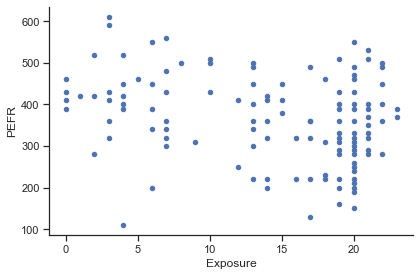

In [21]:
# Figure 4-1
lung = pd.read_csv(LUNG_CSV)

lung.plot.scatter(x='Exposure', y='PEFR', c="b")

plt.tight_layout()
plt.show()

Simple linear regression tries to find the “best” line to predict the response `PEFR` as a function of the predictor variable `Exposure`:

$$\text{PERF} = b_0 + b_1\text{Exposure}$$

We can use the `LinearRegression` model from _scikit-learn_ (the `statsmodels` package has a linear regression implementation that is more similar to R (`sm.OLS`); we will use it later in this chapter).

In [22]:
# Conducting a simple linear reg with scikit-learn
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


The intercept, or $b_0$, is $424.583$ and can be interpreted as the predicted `PEFR` for a worker with *zero years exposure*. The regression coefficient, or $b_1$, can be interpreted as follows: for each *additional year* that a worker is exposed to cotton dust, the worker’s `PEFR` measurement is reduced by $–4.185$.

The regression line from this model is displayed in Figure 4-2.

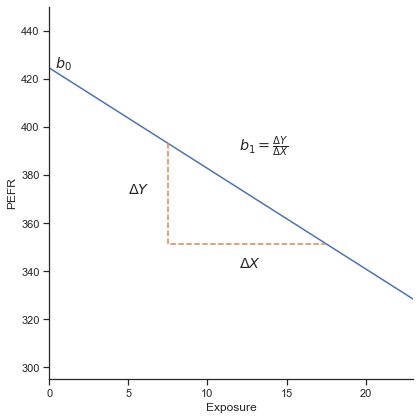

In [25]:
# Figure 4-2
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict([[0], [23]]))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

### Fitted Values and Residuals

Important concepts in regression analysis are the *fitted values* (the predictions) and *residuals* (prediction errors). In general, the data doesn’t fall exactly on a line, so the regression equation should include an explicit error term $e_i$:
$$Y_i = b_0 + b_1X_i + e_i$$

The fitted values, also referred to as the *predicted values*, are typically denoted by $\hat{Y}_i$ (Y-hat). These are given by:
$$\hat{Y}_i = \hat{b}_0 + \hat{b}_1X_i$$

The notation $\hat{b}_0$ and $\hat{b}_1$ indicates that the coefficients are estimated versus known.

**Hat Notation: Estimates Versus Known Values**

> The “hat” notation is used to differentiate between estimates and known values. So the symbol $\hat{b}$
(“b-hat”) is an estimate of the unknown parameter . Why do statisticians differentiate between the estimate and the true value? The estimate has uncertainty, whereas the true value is fixed.

We compute the residuals $\hat{e}_i$ by subtracting the predicted values from the original data:
$$ \hat{e}_i = Y_i - \hat{Y}_i$$

With `scikit-learn`’s `LinearRegression` model, we use the `predict` method on the training data to get the fitted values and subsequently the residuals. As we will see, this is a general pattern that all models in scikit-learn follow:

In [26]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

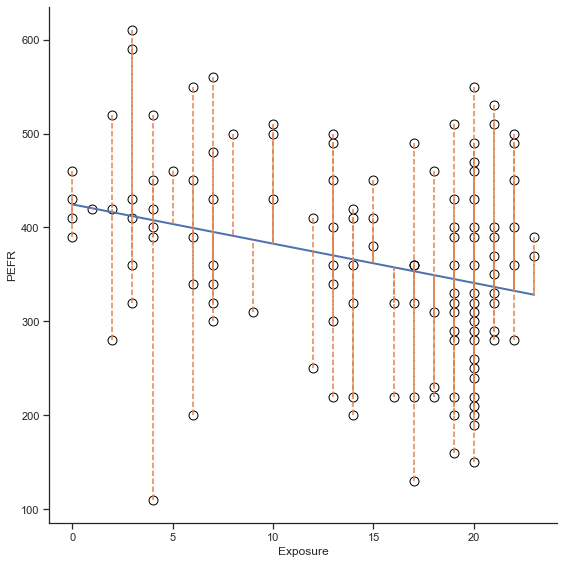

In [76]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(8, 8), color="none", s=80, edgecolor="black", lw=1)
ax.plot(lung.Exposure, fitted, lw=2)

for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted): 
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

### Least Squares

How is the model fit to the data? When there is a clear relationship, you could imagine fitting the line by hand. In practice, the regression line is the estimate that minimizes the sum of squared residual values, also called the *residual sum of squares* or *RSS*:

$$ \begin{align*} RSS &= \sum_{i=1}^n(Y_i - \hat{Y}_i)^2 \\ &= \sum_{i=1}^n (Y_i - \hat{b}_0 - \hat{b}_1X_i)^2 \end{align*}$$

The estiamtes $\hat{b}_0$ and $\hat{b}_1$ are the values that minimize RSS.

The method of minimizing the sum of the squared residuals is termed *least squares* regression, or *ordinary least squares* (OLS) regression. It is often attributed to Carl Friedrich Gauss, the German mathematician, but was first published by the French mathematician Adrien-Marie Legendre in 1805. Least squares regression can be computed quickly and easily with any standard statistical software.

Historically, computational convenience is one reason for the widespread use of least squares in regression. With the advent of big data, computational speed is still an important factor. Least squares, like the mean (see “Median and Robust Estimates”), are sensitive to outliers, although this tends to be a significant problem only in small or moderate-sized data sets. See “Outliers” for a discussion of outliers in regression.

**Regression Terminology**

When analysts and researchers use the term regression by itself, they are typically referring to linear regression; the focus is usually on developing a linear model to explain the relationship between predictor variables and a numeric outcome variable. In its formal statistical sense, regression also includes *nonlinear* models that yield a functional relationship between predictors and outcome variables. In the machine learning community, the term is also occasionally used loosely to refer to the use of any predictive model that produces a predicted numeric outcome (as opposed to classification methods that predict a binary or categorical outcome).



**Key Ideas**

- The regression equation models the relationship between a response variable $Y$ and a predictor variable $X$ as a line.
- A regression model yields *fitted values* and *residuals*—predictions of the response and the errors of the predictions.
- Regression models are typically fit by the method of *least squares*.
- Regression is used both for prediction and explanation.

## Multiple linear regression

When there are multiple predictors, the equation is simply extended to accommodate them:
$$Y = b_0 + b_1X_1 + b_2X_2 + \ldots{} + b_pX_p + e$$

Instead of a line, we now have a linear model—the relationship between each coefficient and its variable (feature) is linear.

**Key Terms for Multiple Linear Regression**

**Root mean squared error**

The square root of the average squared error of the regression (this is the most widely used metric to compare regression models).

Synonym: 
- RMSE

**Residual standard error**

The same as the root mean squared error, but adjusted for degrees of freedom.

Synonym:
- RSE

**R-squared**

The proportion of variance explained by the model, from 0 to 1.

Synonyms:
- coefficient of determination, $R^2$

**t-statistic**

The coefficient for a predictor, divided by the standard error of the coefficient, giving a metric to compare the importance of variables in the model. See “t-Tests”.

**Weighted regression**

Regression with the records having different weights.

All of the other concepts in simple linear regression, such as fitting by least squares and the definition of fitted values and residuals, extend to the multiple linear regression setting. For example, the fitted values are given by:

$$\hat{Y}_i = \hat{b}_0 + \hat{b}_1X_{1,i}+\hat{b}_2X_{2,i} + \ldots{} + \hat{b}_pX_{p,i}$$

### Example: King County Housing Data

An example of using multiple linear regression is in estimating the value of houses. County assessors must estimate the value of a house for the purposes of assessing taxes. Real estate professionals and home buyers consult popular websites such as Zillow to ascertain a fair price. Here are a few rows of housing data from King County (Seattle), Washington, from the `house data.frame`:

In [77]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


The goal is to predict the sales price from the other variables. `scikit-learn`’s `LinearRegression` can be used for multiple linear regression as well:

In [79]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

LinearRegression()

For a `LinearRegression` model, intercept and coefficients are the fields `intercept_` and `coef_` of the fitted model:

In [80]:
print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240734
 SqFtLot: -0.06046682065304124
 Bathrooms: -19442.84039832112
 Bedrooms: -47769.95518521436
 BldgGrade: 106106.96307898109


The interpretation of the coefficients is as with simple linear regression: the predicted value $\hat{Y}$ changes by the coefficient $b_j$ for each unit change in $X_j$ assuming all the other variables, $X_k$ for $k\neq{}j$, remain the same. For example, adding an extra finished square foot to a house increases the estimated value by roughly \$229; adding 1,000 finished square feet implies the value will increase by \$228,800.

### Assessing the Model

The most important performance metric from a data science perspective is *root mean squared error*, or *RMSE*. RMSE is the square root of the average squared error in the predicted $\hat{y}_i$ values:
$$ RMSE = \sqrt{\cfrac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{n}} $$

This measures the overall accuracy of the model and is a basis for comparing it to other models (including models fit using machine learning techniques). Similar to RMSE is the *residual standard error*, or *RSE*. In this case we have $p$ predictors, and the RSE is given by:
$$ RSE = \sqrt{\cfrac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{(n - p - 1)}} $$

The only difference is that the denominator is the degrees of freedom, as opposed to number of records (see “Degrees of Freedom”). In practice, for linear regression, the difference between RMSE and RSE is very small, particularly for big data applications.

_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score`.

In [81]:
fitted = house_lm.predict(house[predictors])

RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


While `scikit-learn` provides a variety of different metrics, `statsmodels` provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to `scikit-learn` and one that allows specifying `R`-style formulas. Here we use the first approach. As `statsmodels` doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the `pandas` method assign for this.

In [82]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:06:15   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

Another useful metric that you will see in software output is the *coefficient of determination*, also called the *R-squared* statistic or $R^2$. R-squared ranges from 0 to 1 and measures the proportion of variation in the data that is accounted for in the model. It is useful mainly in explanatory uses of regression where you want to assess how well the model fits the data. The formula for $R^2$ is:
$$ R^2 = 1 - \cfrac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2} $$

The denominator is proportional to the variance of $Y$. The output from `R` also reports an *adjusted R-squared*, which adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model. Seldom is this significantly different from R-squared in multiple regression with large data sets.

Along with the estimated coefficients, `R` and `statsmodels` report the standard error of the coefficients (SE) and a `t-statistic`:
$$ t_b = \cfrac{\hat{b}}{SE(\hat{b})} $$

The t-statistic—and its mirror image, the p-value—measures the extent to which a coefficient is “statistically significant”—that is, outside the range of what a random chance arrangement of predictor and target variable might produce. The higher the t-statistic (and the lower the p-value), the more significant the predictor. Since parsimony is a valuable model feature, it is useful to have a tool like this to guide choice of variables to include as predictors (see “Model Selection and Stepwise Regression”).

**Warning**

> In addition to the t-statistic, R and other packages will often report a *p-value* ($Pr(>|t|)$ in the R output) and *F-statistic*. Data scientists do not generally get too involved with the interpretation of these statistics, nor with the issue of statistical significance. Data scientists primarily focus on the t-statistic as a useful guide for whether to include a predictor in a model or not. High t-statistics (which go with p-values near 0) indicate a predictor should be retained in a model, while very low t-statistics indicate a predictor could be dropped. See “p-Value” for more discussion.


### Model Selection and Stepwise Regression

In some problems, many variables could be used as predictors in a regression. For example, to predict house value, additional variables such as the basement size or year built could be used.

In Python, we need to convert the categorical and boolean variables into numbers:

In [83]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:14:46   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

Adding more variables, however, does not necessarily mean we have a better model. Statisticians use the principle of *Occam’s razor* to guide the choice of a model: all things being equal, a simpler model should be used in preference to a more complicated model.

Including additional variables always reduces RMSE and increases $R^2$ for the training data. Hence, these are not appropriate to help guide the model choice. One approach to including model complexity is to use the adjusted $R^2$:
$$ R^2_{adj} = 1 - (1 - R^2)\cfrac{n - 1}{n - P - 1} $$

Here, $n$ is the number of records and $P$ is the number of variables in the model.

In the 1970s, Hirotugu Akaike, the eminent Japanese statistician, developed a metric called *AIC* (Akaike’s Information Criteria) that penalizes adding terms to a model. In the case of regression, AIC has the form:
$$ AIC = 2P + n\log{\cfrac{RSS}{n}} $$

where $P$ is the number of variables, and $n$ the number of records. The goal is to find the model that minimizes AIC; models with $k$ more extra variables are penalized by $2k$.

These are typically reported as in-sample metrics (i.e., on the training data), and data scientists using holdout data for model assessment do not need to worry about the differences among them or the underlying theory behind them.

How do we find the model that minimizes AIC or maximizes adjusted $R^2$? One way is to search through all possible models, an approach called all subset regression. This is computationally expensive and is not feasible for problems with large data and many variables. 

An attractive alternative is to use *stepwise regression*. It could start with a full model and successively drop variables that don’t contribute meaningfully. This is called *backward elimination*. Alternatively one could start with a constant model and successively add variables (*forward selection*). As a third option we can also successively add and drop predictors to find a model that lowers AIC or adjusted $R^2$.

`scikit-learn` has no implementation for stepwise regression. We implemented functions `stepwise_selection`, `forward_selection`, and `backward_elimination` in our dmba package:

In [84]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420157
 BldgGrade: 137159.56022620026
 YrBuilt: -3565.4249392493302
 Bedrooms: -51947.38367361384
 Bathrooms: 42396.16452771885
 PropertyType_Townhouse: 84479.16203300121
 SqFtFinBasement: 7.046974967572117
 PropertyType_Single Family: 22912.05518701784


Stepwise regression and all subset regression are *in-sample* methods to assess and tune models. This means the model selection is possibly subject to overfitting (fitting the noise in the data) and may not perform as well when applied to new data. One common approach to avoid this is to use cross-validation to validate the models. In linear regression, overfitting is typically not a major issue, due to the simple (linear) global structure imposed on the data. For more sophisticated types of models, particularly iterative procedures that respond to local data structure, cross-validation is a very important tool; see “Cross-Validation” for details.

### Weighted regression
We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [85]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005

In [86]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
5,intercept,-521871.368188,-584189.329446


In [88]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
#axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
#axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


**Key Ideas**

- Multiple linear regression models the relationship between a response variable $Y$ and multiple predictor variables $X_1,\ldots{},X_p$.
- The most important metrics to evaluate a model are root mean squared error (RMSE) and R-squared ($R^2$).
- The standard error of the coefficients can be used to measure the reliability of a variable’s contribution to a model.
- Stepwise regression is a way to automatically determine which variables should be included in the model.
- Weighted regression is used to give certain records more or less weight in fitting the equation.


## Prediction Using Regression

The primary purpose of regression in data science is prediction. This is useful to keep in mind, since regression, being an old and established statistical method, comes with baggage that is more relevant to its traditional role as a tool for explanatory modeling than to prediction.

**Key Terms for Prediction Using Regression**

**Prediction interval**

An uncertainty interval around an individual predicted value.

**Extrapolation**

Extension of a model beyond the range of the data used to fit it.

### The Dangers of Extrapolation

Regression models should not be used to extrapolate beyond the range of the data (leaving aside the use of regression for time series forecasting.). The model is valid only for predictor values for which the data has sufficient values (even in the case that sufficient data is available, there could be other problems—see “Regression Diagnostics”). As an extreme case, suppose `model_lm` is used to predict the value of a 5,000-square-foot empty lot. In such a case, all the predictors related to the building would have a value of 0, and the regression equation would yield an absurd prediction of $–521,900 + 5,000 × –.0605 = –\$522,202$. Why did this happen? The data contains only parcels with buildings—there are no records corresponding to vacant land. Consequently, the model has no information to tell it how to predict the sales price for vacant land.

### Confidence and Prediction Intervals

Much of statistics involves understanding and measuring variability (uncertainty). The t-statistics and p-values reported in regression output deal with this in a formal way, which is sometimes useful for variable selection (see “Assessing the Model”). More useful metrics are confidence intervals, which are uncertainty intervals placed around regression coefficients and predictions. An easy way to understand this is via the bootstrap (see “The Bootstrap” for more details about the general bootstrap procedure). The most common regression confidence intervals encountered in software output are those for regression parameters (coefficients). Here is a bootstrap algorithm for generating confidence intervals for regression parameters (coefficients) for a data set with $P$ predictors and $n$ records (rows):

1. Consider each row (including outcome variable) as a single “ticket” and place all the $n$ tickets in a box.
2. Draw a ticket at random, record the values, and replace it in the box.
3. Repeat step 2 $n$ times; you now have one bootstrap resample.
4. Fit a regression to the bootstrap sample, and record the estimated coefficients.
5. Repeat steps 2 through 4, say, 1,000 times.
6. You now have 1,000 bootstrap values for each coefficient; find the appropriate percentiles for each one (e.g., 5th and 95th for a 90% confidence interval).

The individual data point error can be thought of as follows: even if we knew for certain what the regression equation was (e.g., if we had a huge number of records to fit it), the actual outcome values for a given set of predictor values will vary. For example, several houses—each with 8 rooms, a 6,500-square-foot lot, 3 bathrooms, and a basement—might have different values. We can model this individual error with the residuals from the fitted values. The bootstrap algorithm for modeling both the regression model error and the individual data point error would look as follows:

1. Take a bootstrap sample from the data (spelled out in greater detail earlier).
2. Fit the regression, and predict the new value.
3. Take a single residual at random from the original regression fit, add it to the predicted value, and record the result.
4. Repeat steps 1 through 3, say, 1,000 times.
5. Find the 2.5th and the 97.5th percentiles of the results.

**Key Ideas**

- Extrapolation beyond the range of the data can lead to error.
- Confidence intervals quantify uncertainty around regression coefficients.
- Prediction intervals quantify uncertainty in individual predictions.
- Most software, R included, will produce prediction and confidence intervals in default or specified output, using formulas.
- The bootstrap can also be used to produce prediction and confidence intervals; the interpretation and idea are the same.

**Prediction Interval or Confidence Interval?Ü**

> A prediction interval pertains to uncertainty around a single value, while a confidence interval pertains to a mean or other statistic calculated from multiple values. Thus, a prediction interval will typically be much wider than a confidence interval for the same value. We model this individual value error in the bootstrap model by selecting an individual residual to tack on to the predicted value. Which should you use? That depends on the context and the purpose of the analysis, but, in general, data scientists are interested in specific individual predictions, so a **prediction interval** would be more appropriate. Using a confidence interval when you should be using a prediction interval will greatly underestimate the uncertainty in a given predicted value.


## Factor variables in regression

Factor variables, also termed categorical variables, take on a limited number of discrete values. For example, a loan purpose can be “debt consolidation,” “wedding,” “car,” and so on. The binary (yes/no) variable, also called an indicator variable, is a special case of a factor variable. Regression requires numerical inputs, so factor variables need to be recoded to use in the model. The most common approach is to convert a variable into a set of binary dummy variables.


**Key Terms for Factor Variables**

**Dummy variables**

Binary 0–1 variables derived by recoding factor data for use in regression and other models.

**Reference coding**

The most common type of coding used by statisticians, in which one level of a factor is used as a reference and other factors are compared to that level.

Synonym:
- treatment coding

**One hot encoder**

A common type of coding used in the machine learning community in which all factor levels are retained. While useful for certain machine learning algorithms, this approach is not appropriate for multiple linear regression.

**Deviation coding**

A type of coding that compares each level against the overall mean as opposed to the reference level.

Synonym:
- sum contrasts

### Dummy Variables Representation

In the King County housing data, there is a factor variable for the property type; a small subset of six records is shown below:

In [90]:
house.PropertyType.head()

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object

There are three possible values: `Multiplex`, `Single Family`, and `Townhouse`. 

In [91]:
house.PropertyType.unique()

array(['Multiplex', 'Single Family', 'Townhouse'], dtype=object)

In Python, we can convert categorical variables to dummies using the pandas method `get_dummies`:

In [95]:
pd.get_dummies(house['PropertyType']).head(6)  # By default, returns one hot encoding of the categorical variable.

,Multiplex,Single Family,Townhouse
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
6,0,0,1


In [96]:
pd.get_dummies(house['PropertyType'], drop_first=True).head(6)  # The keyword argument drop_first will return P – 1 columns. Use this to avoid the problem of multicollinearity.

,Single Family,Townhouse
1,0,0
2,1,0
3,1,0
4,1,0
5,1,0
6,0,1


In certain machine learning algorithms, such as nearest neighbors and tree models, one hot encoding is the standard way to represent factor variables (for example, see “Tree Models”).

In the regression setting, a factor variable with $P$ distinct levels is usually represented by a matrix with only $P – 1$ columns. This is because a regression model typically includes an intercept term. With an intercept, once you have defined the values for $P – 1$ binaries, the value for the $P$th is known and could be considered redundant. Adding the $P$th column will cause a *multicollinearity error* (see “Multicollinearity”).

The method `get_dummies` takes the optional keyword argument `drop_first` to exclude the first factor as reference:

In [97]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503768
 SqFtLot: -0.07036798136812013
 Bathrooms: -15979.013473415245
 Bedrooms: -50889.73218483017
 BldgGrade: 109416.30516146199
 PropertyType_Single Family: -84678.21629549243
 PropertyType_Townhouse: -115121.97921609167


**Different Factor Codings**

> There are several different ways to encode factor variables, known as contrast coding systems. For example, deviation coding, also known as sum contrasts, compares each level against the overall mean. Another contrast is polynomial coding, which is appropriate for ordered factors; see the section “Ordered Factor Variables”. With the exception of ordered factors, data scientists will generally not encounter any type of coding besides reference coding or one hot encoder.


### Factor Variables with many levels

Some factor variables can produce a huge number of binary dummies—zip codes are a factor variable, and there are 43,000 zip codes in the US. In such cases, it is useful to explore the data, and the relationships between predictor variables and the outcome, to determine whether useful information is contained in the categories. If so, you must further decide whether it is useful to retain all factors, or whether the levels should be consolidated.

In King County, there are 80 zip codes with a house sale. The `value_counts` method of pandas data frames returns the same information:

In [104]:
pd.DataFrame(house['ZipCode'].value_counts())

,ZipCode
98038,788
98103,671
98042,641
98115,620
98117,619
...,...
98288,4
98224,3
98068,1
98113,1


ZipCode is an important variable, since it is a *proxy* for the effect of location on the value of a house. Including all levels requires $79$ coefficients corresponding to 79 degrees of freedom. The original model `house_lm` has only 5 degrees of freedom; see “Assessing the Model”. Moreover, several zip codes have only one sale. In some problems, you can consolidate a zip code using the first two or three digits, corresponding to a submetropolitan geographic region. For King County, almost all of the sales occur in 980xx or 981xx, so this doesn’t help.



An alternative approach is to group the zip codes according to another variable, such as sale price. Even better is to form zip code groups using the residuals from an initial model. See “Confounding Variables” for an example of how this is used as a term in a regression improving upon the original fit.

In Python we can calculate this information as follows:

In [106]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')

zip_groups

,ZipCode,count,median_residual
36,98057,4,-537321.644462
27,98043,1,-307661.343614
46,98092,289,-193569.183599
23,98038,788,-150066.477035
31,98051,32,-142352.869593
...,...,...,...
60,98119,260,174462.549290
54,98112,357,232788.487256
25,98040,244,254004.002463
3,98004,293,383596.028729


In [109]:
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [119]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

In [120]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,6,7,1991,0,0,70000,229000,98002,False,2
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,4,10,2005,0,0,203000,590000,98166,True,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,4,8,1947,0,0,183000,275000,98166,False,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,5,7,1966,0,0,104000,229000,98168,False,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,4,7,1948,0,0,104000,205000,98168,False,2


### Ordered Factor Variables

Some factor variables reflect levels of a factor; these are termed *ordered factor variables* or *ordered categorical variables*. For example, the loan grade could be A, B, C, and so on—each grade carries more risk than the prior grade. Often, ordered factor variables can be converted to numerical values and used as is. For example, the variable `BldgGrade` is an ordered factor variable. Several of the types of grades are shown in Table 4-1. While the grades have specific meaning, the numeric value is ordered from low to high, corresponding to higher-grade homes. With the regression model `house_lm`, fit in “Multiple Linear Regression”, `BldgGrade` was treated as a numeric variable.

In [115]:
house.BldgGrade.value_counts()

7     9501
8     6257
9     2825
6     2109
10    1206
11     439
5      198
12     121
13      18
4       12
3        1
Name: BldgGrade, dtype: int64

Treating ordered factors as a numeric variable preserves the information contained in the ordering that would be lost if it were converted to a factor.

**Key Ideas**

- Factor variables need to be converted into numeric variables for use in a regression.
- The most common method to encode a factor variable with $P$ distinct values is to represent them using $P – 1$ *dummy variables*.
- A factor variable with many levels, even in very big data sets, may need to be consolidated into a variable with fewer levels.
- Some factors have levels that are ordered and can be represented as a single numeric variable.

## Interpreting the Regression Equation

In data science, the most important use of regression is to predict some dependent (outcome) variable. In some cases, however, gaining insight from the equation itself to understand the nature of the relationship between the predictors and the outcome can be of value. This section provides guidance on examining the regression equation and interpreting it.

**Key Terms for Interpreting the Regression Equation**

**Correlated variables**

Variables that tend to move in the same direction—when one goes up so does the other, and vice-versa (with negative correlation, when one goes up the other does down). When the predictor variables are highly correlated, it is difficult to interpret the individual coefficients.

**Multicollinearity**

When the predictor variables have perfect, or near-perfect, correlation, the regression can be unstable or impossible to compute.

Synonym:
- collinearity

**Confounding variables**

An important predictor that, when omitted, leads to spurious relationships in a regression equation.

**Main effects**

The relationship between a predictor and the outcome variable, independent of other variables.

**Interactions**

An interdependent relationship between two or more predictors and the response.

### Correlated predictors

In multiple regression, the predictor variables are often correlated with each other. As an example, examine the regression coefficients for the model `step_lm`, fit in “Model Selection and Stepwise Regression”.

The results from the stepwise regression are.

In [116]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.2775530420157
 BldgGrade: 137159.56022620026
 YrBuilt: -3565.4249392493302
 Bedrooms: -51947.38367361384
 Bathrooms: 42396.16452771885
 PropertyType_Townhouse: 84479.16203300121
 SqFtFinBasement: 7.046974967572117
 PropertyType_Single Family: 22912.05518701784


The coefficient for Bedrooms is negative! This implies that adding a bedroom to a house will reduce its value. How can this be? This is because the predictor variables are *correlated*: larger houses tend to have more bedrooms, and it is the size that drives house value, not the number of bedrooms. Consider two homes of the exact same size: it is reasonable to expect that a home with more but smaller bedrooms would be considered less desirable.

Having correlated predictors can make it difficult to interpret the sign and value of regression coefficients (and can inflate the standard error of the estimates). The variables for bedrooms, house size, and number of bathrooms are all correlated. In Python, there is no equivalent to R’s update function. We need to refit the model with the modified predictor list:

In [117]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230215294
 BldgGrade: 248997.79366213747
 YrBuilt: -3211.7448621550966
 PropertyType_Single Family: -19898.49534050217
 PropertyType_Townhouse: -47355.43687334463


Correlated variables are only one issue with interpreting regression coefficients. In `house_lm`, there is no variable to account for the location of the home, and the model is mixing together very different types of regions. Location may be a confounding variable; see “Confounding Variables” for further discussion.

### Multicollinearity

An extreme case of correlated variables produces *multicollinearity*—a condition in which there is redundance among the predictor variables. Perfect multicollinearity occurs when one predictor variable can be expressed as a linear combination of others. Multicollinearity occurs when:

- A variable is included multiple times by error.
- $P$ dummies, instead of $P – 1$ dummies, are created from a factor variable (see “Factor Variables in Regression”).
- Two variables are nearly perfectly correlated with one another.
  

Multicollinearity in regression must be addressed—variables should be removed until the multicollinearity is gone. A regression does not have a well-defined solution in the presence of perfect multicollinearity. Many software packages, including R and Python, automatically handle certain types of multicollinearity. For example, if SqFtTotLiving is included twice in the regression of the house data, the results are the same as for the house_lm model. In the case of nonperfect multicollinearity, the software may obtain a solution, but the results may be unstable.

**Note**

Multicollinearity is not such a problem for nonlinear regression methods like trees, clustering, and nearest-neighbors, and in such methods it may be advisable to retain $P$ dummies (instead of $P – 1$). That said, even in those methods, nonredundancy in predictor variables is still a virtue.


### Confounding variables

With correlated variables, the problem is one of commission: including different variables that have a similar predictive relationship with the response. With *confounding variables*, the problem is one of omission: an important variable is *not included* in the regression equation. Naive interpretation of the equation coefficients can lead to invalid conclusions.

Take, for example, the King County regression equation `house_lm` from “Example: King County Housing Data”. The regression coefficients of `SqFtLot`, `Bathrooms`, and `Bedrooms` are all negative. The original regression model does not contain a variable to represent location—a very important predictor of house price. To model location, include a variable `ZipGroup` that categorizes the zip code into one of five groups, from least expensive (1) to most expensive (5):

In [121]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.6126600558018
 SqFtLot: 0.45498713854659495
 Bathrooms: 5928.425640001686
 Bedrooms: -41682.871840744796
 BldgGrade: 98541.18352725952
 PropertyType_Single Family: 19323.625287919327
 PropertyType_Townhouse: -78198.72092762393
 ZipGroup_1: 53317.173306598124
 ZipGroup_2: 116251.5888356357
 ZipGroup_3: 178360.53178793387
 ZipGroup_4: 338408.6018565202


`ZipGroup` is clearly an important variable: a home in the most expensive zip code group is estimated to have a higher sales price by almost \$340,000. The coefficients of `SqFtLot` and `Bathrooms` are now positive, and adding a bathroom increases the sale price by \$5,928.

The coefficient for `Bedrooms` is still negative. While this is unintuitive, this is a well-known phenomenon in real estate. For homes of the same livable area and number of bathrooms, having more and therefore smaller bedrooms is associated with less valuable homes.

### Interactions and Main Effects

Statisticians like to distinguish between main effects, or independent variables, and the interactions between the main effects. Main effects are what are often referred to as the predictor variables in the regression equation. An implicit assumption when only main effects are used in a model is that the relationship between a predictor variable and the response is independent of the other predictor variables. This is often not the case.

For example, the model fit to the King County Housing Data in “Confounding Variables” includes several variables as main effects, including ZipCode. Location in real estate is everything, and it is natural to presume that the relationship between, say, house size and the sale price depends on location. A big house built in a low-rent district is not going to retain the same value as a big house built in an expensive area.

In Python, we need to use the statsmodels package to train linear regression models with interactions. This package was designed similar to R and allows defining models using a formula interface:

In [122]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:50:55   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

> Results differ from R due to different binning. Enforcing the same binning gives identical results

The `statsmodels` package takes care of categorical variables (e.g., `ZipGroup[T.1]`, `PropertyType[T.Single Family]`) and interaction terms (e.g., `SqFtTotLiving:ZipGroup[T.1]`).

Location and house size appear to have a strong interaction. For a home in the lowest ZipGroup, the slope is the same as the slope for the main effect `SqFtTotLiving`, which is \$118 per square foot (this is because R uses reference coding for factor variables; see “Factor Variables in Regression”). For a home in the highest `ZipGroup`, the slope is the sum of the main effect plus `SqFtTotLiving:ZipGroup5`, or $\$115 + \$227 = \$342$ per square foot. In other words, adding a square foot in the most expensive zip code group boosts the predicted sale price by a factor of almost three, compared to the average boost from adding a square foot.

**Model Selection with Interaction Terms**

In problems involving many variables, it can be challenging to decide which interaction terms should be included in the model. Several different approaches are commonly taken:

- In some problems, prior knowledge and intuition can guide the choice of which interaction terms to include in the model.
- Stepwise selection (see “Model Selection and Stepwise Regression”) can be used to sift through the various models.
- Penalized regression can automatically fit to a large set of possible interaction terms.
- Perhaps the most common approach is to use *tree models*, as well as their descendants, *random forest* and *gradient boosted trees*. This class of models automatically searches for optimal interaction terms; see “Tree Models”.

**Key Ideas**

- Because of correlation between predictors, care must be taken in the interpretation of the coefficients in multiple linear regression.
- Multicollinearity can cause numerical instability in fitting the regression equation.
- A confounding variable is an important predictor that is omitted from a model and can lead to a regression equation with spurious relationships.
- An interaction term between two variables is needed if the relationship between the variables and the response is interdependent.

## Regression Diagnostics

In explanatory modeling (i.e., in a research context), various steps, in addition to the metrics mentioned previously (see “Assessing the Model”), are taken to assess how well the model fits the data; most are based on analysis of the residuals. These steps do not directly address predictive accuracy, but they can provide useful insight in a predictive setting.

# Testing the Assumptions: Regression Diagnostics
## Outliers

The _statsmodels_ package has the most developed support for outlier analysis. 

In [30]:
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          1.69e-103
Time:                        15:56:26   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

The `OLSInfluence` class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals. 

In [31]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.3267318040785625


In [32]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115827


In [33]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


## Influential values

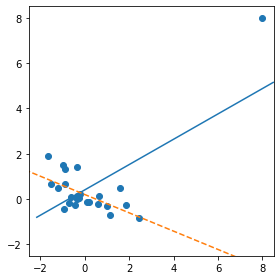

In [34]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

The package _statsmodel_ provides a number of plots to analyze the data point influence

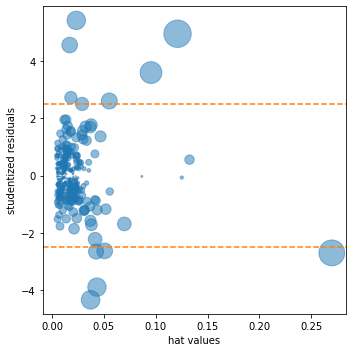

In [35]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [36]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Heteroskedasticity, Non-Normality and Correlated Errors

The `regplot` in _seaborn_ allows adding a lowess smoothing line to the scatterplot.

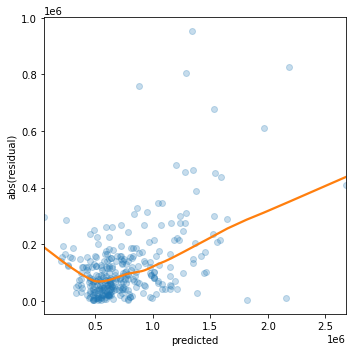

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

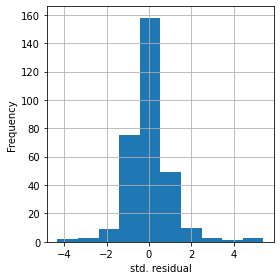

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

## Partial Residual Plots and Nonlinearity

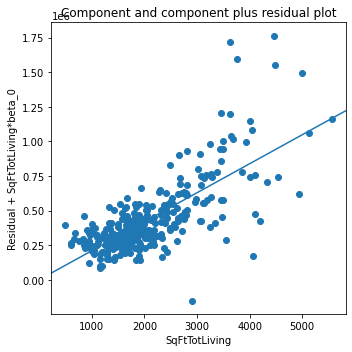

In [39]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

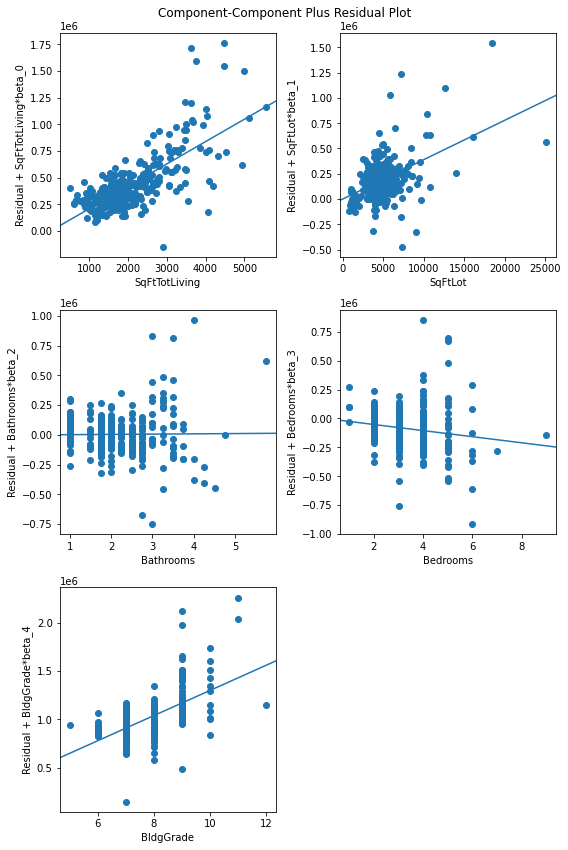

In [40]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## Polynomial and Spline Regression

In [41]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          9.95e-106
Time:                        15:56:28   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

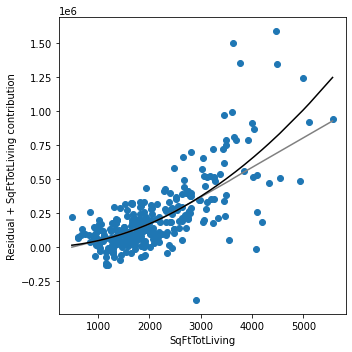

0.03879128168236527


In [42]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Splines

In [43]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 23 Feb 2021   Prob (F-statistic):          7.10e-104
Time:                        15:56:28   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


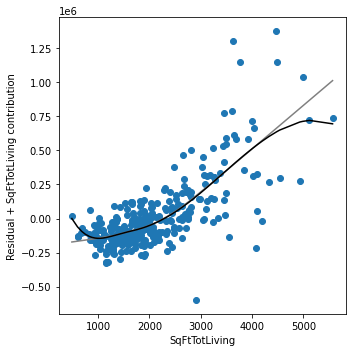

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

## Generalized Additive Models

In [45]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:  00:00:00


 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                       30838885095.172
                                                Scale:                                    29480381715.8334
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

<ipython-input-1-2454e06428fa>:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


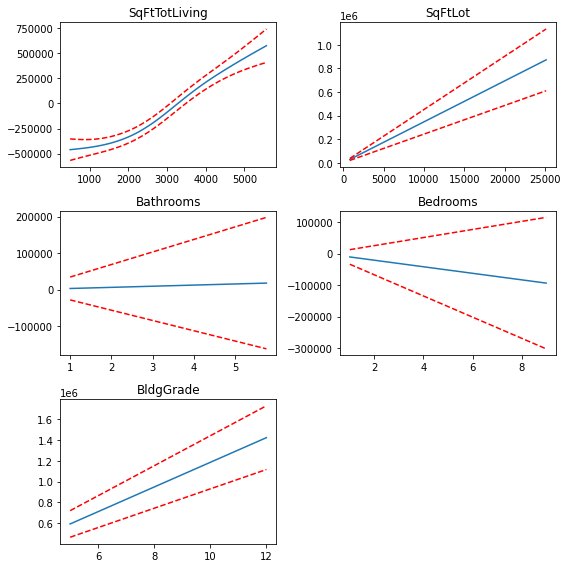

In [46]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# Additional material - not in book
# Regularization
## Lasso

In [47]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [48]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [49]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression()


In [50]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10)


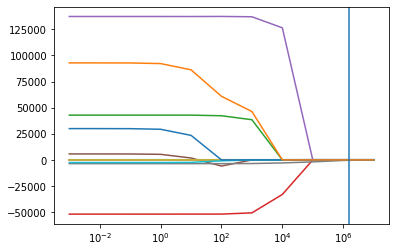

In [51]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [52]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

,name,coef
0,SqFtTotLiving,289.048846
1,SqFtLot,0.029471
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.316479
7,YrBuilt,-0.000000
8,YrRenovated,45.727472
9,NewConstruction,-0.000000


In [53]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308